# Moteur de recommandation de films : nettoyage & exploration
Important : le fichier de données doit se trouver dans le répertoire courant.

## Initialisation

In [1]:
from IPython.display import display
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MultiLabelBinarizer
import sys
import warnings

pd.options.display.float_format = '{:,.3f}'.format
input_file = 'movie_metadata.csv'
output_file = 'imdb.csv'
print(f"Version de matplotlib : {matplotlib.__version__}")
print(f"Version de pandas : {pd.__version__}")
print(f"Version de Python : {sys.version}")

Version de matplotlib : 3.0.3
Version de pandas : 0.24.2
Version de Python : 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


## Chargement et nettoyage des données 

### Chargement

In [2]:
data = pd.read_csv(input_file, delimiter=',')
print(data.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
color                        5024 non-null object
director_name                4939 non-null object
num_critic_for_reviews       4993 non-null float64
duration                     5028 non-null float64
director_facebook_likes      4939 non-null float64
actor_3_facebook_likes       5020 non-null float64
actor_2_name                 5030 non-null object
actor_1_facebook_likes       5036 non-null float64
gross                        4159 non-null float64
genres                       5043 non-null object
actor_1_name                 5036 non-null object
movie_title                  5043 non-null object
num_voted_users              5043 non-null int64
cast_total_facebook_likes    5043 non-null int64
actor_3_name                 5020 non-null object
facenumber_in_poster         5030 non-null float64
plot_keywords                4890 non-null object
movie_imdb_link              5043 non-

### Affichage d'un échantillon

In [3]:
data.head(10)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.000,178.000,0.000,855.000,Joel David Moore,"1,000.000","760,505,847.000",Action|Adventure|Fantasy|Sci-Fi,...,"3,054.000",English,USA,PG-13,"237,000,000.000","2,009.000",936.000,7.900,1.780,33000
1,Color,Gore Verbinski,302.000,169.000,563.000,"1,000.000",Orlando Bloom,"40,000.000","309,404,152.000",Action|Adventure|Fantasy,...,"1,238.000",English,USA,PG-13,"300,000,000.000","2,007.000","5,000.000",7.100,2.350,0
2,Color,Sam Mendes,602.000,148.000,0.000,161.000,Rory Kinnear,"11,000.000","200,074,175.000",Action|Adventure|Thriller,...,994.000,English,UK,PG-13,"245,000,000.000","2,015.000",393.000,6.800,2.350,85000
3,Color,Christopher Nolan,813.000,164.000,"22,000.000","23,000.000",Christian Bale,"27,000.000","448,130,642.000",Action|Thriller,...,"2,701.000",English,USA,PG-13,"250,000,000.000","2,012.000","23,000.000",8.500,2.350,164000
4,NaN,Doug Walker,nan,nan,131.000,nan,Rob Walker,131.000,nan,Documentary,...,nan,NaN,NaN,NaN,nan,nan,12.000,7.100,nan,0
5,Color,Andrew Stanton,462.000,132.000,475.000,530.000,Samantha Morton,640.000,"73,058,679.000",Action|Adventure|Sci-Fi,...,738.000,English,USA,PG-13,"263,700,000.000","2,012.000",632.000,6.600,2.350,24000
6,Color,Sam Raimi,392.000,156.000,0.000,"4,000.000",James Franco,"24,000.000","336,530,303.000",Action|Adventure|Romance,...,"1,902.000",English,USA,PG-13,"258,000,000.000","2,007.000","11,000.000",6.200,2.350,0
7,Color,Nathan Greno,324.000,100.000,15.000,284.000,Donna Murphy,799.000,"200,807,262.000",Adventure|Animation|Comedy|Family|Fantasy|Musi...,...,387.000,English,USA,PG,"260,000,000.000","2,010.000",553.000,7.800,1.850,29000
8,Color,Joss Whedon,635.000,141.000,0.000,"19,000.000",Robert Downey Jr.,"26,000.000","458,991,599.000",Action|Adventure|Sci-Fi,...,"1,117.000",English,USA,PG-13,"250,000,000.000","2,015.000","21,000.000",7.500,2.350,118000
9,Color,David Yates,375.000,153.000,282.000,"10,000.000",Daniel Radcliffe,"25,000.000","301,956,980.000",Adventure|Family|Fantasy|Mystery,...,973.000,English,UK,PG,"250,000,000.000","2,009.000","11,000.000",7.500,2.350,10000


### Traitement des valeurs manquantes

#### Répartition des valeurs manquantes

Nombre de lignes contenant des données manquantes : 1287 (25.52 %)


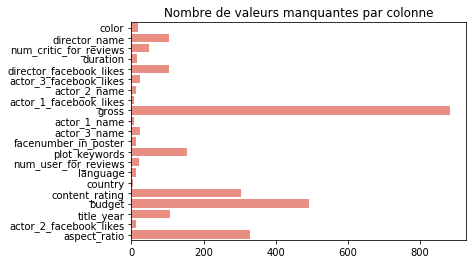

In [4]:
nas_by_col = data.isnull().sum(axis=0)
non_zeros = nas_by_col[nas_by_col != 0]
#print(non_zeros)
total = data.isnull().any(axis=1).sum()
print(f"Nombre de lignes contenant des données manquantes : "
      f"{total} ({total/len(data)*100:0.2f} %)")
axis = sns.barplot(x=non_zeros, y=non_zeros.index, color='salmon')
axis.set_title('Nombre de valeurs manquantes par colonne')

#### Imputation des données manquantes
Pour les colonnes `gross` et `budget` nous remplaçons les valeurs manquantes par des zéros, ce qui revient à considérer les films concernés comme étant peu commerciaux. 

In [5]:
data['gross'].fillna(0, inplace=True)
data['budget'].fillna(0, inplace=True)

Idem pour le nombre de pouces bleus.

In [6]:
fb_cols = [col for col in data.columns if 'facebook_likes' in col]
data[fb_cols] = data[fb_cols].fillna(0, inplace=False)

Nous considérons l'absence de classification comme équivalente à Unrated.

In [7]:
data['content_rating'].fillna('Unrated', inplace=True)

Pour `plot_keywords` et les noms d'acteurs et de réalisateurs, nous remplaçons les valeurs manquantes par des chaînes vides.

In [8]:
data['plot_keywords'].fillna('', inplace=True)
data['director_name'].fillna('', inplace=True)
data['actor_1_name'].fillna('', inplace=True)
data['actor_2_name'].fillna('', inplace=True)
data['actor_3_name'].fillna('', inplace=True)

Nous remplaçons NaN dans la colonne `title_year` par la valeur moyenne.

In [9]:
print(f"Année moyenne de sortie : {int(data['title_year'].mean())}")
data['title_year'].fillna(int(data['title_year'].mean()), inplace=True)

Année moyenne de sortie : 2002


#### Suppression des colonnes inutiles
Plutôt que de les traiter par imputation, nous supprimons certaines colonnes qui rétrospectivement nous semblent peu pertinentes pour faire des recommandations. 

In [10]:
unneeded_cols = ['aspect_ratio', 
                 'color', 
                 'facenumber_in_poster']
data.drop(columns=unneeded_cols, errors='ignore', inplace=True)

#### Nouvelles répartition des valeurs manquantes

In [11]:
totals_by_colon = data.isnull().sum(axis=0)
print(totals_by_colon[totals_by_colon != 0])
print(f"Nombre de lignes contenant des données manquantes : "
      f"{data.isnull().any(axis=1).sum()}")

num_critic_for_reviews    50
duration                  15
num_user_for_reviews      21
language                  12
country                    5
dtype: int64
Nombre de lignes contenant des données manquantes : 73


#### Effacement des lignes contenant des valeurs manquantes
Nous serons probablement amenés à affiner cette approche un peu grossière mais pragmatique, qui vu le faible nombre de lignes concernées n'est pas gênante initialement.

In [12]:
print(f"Taille des données avant effacement : {data.shape}")
data.dropna(inplace=True)
print(f"Nouvelle taille des données : {data.shape}")

Taille des données avant effacement : (5043, 25)
Nouvelle taille des données : (4970, 25)


### Nettoyage : titres

In [13]:
data['movie_title'] = data['movie_title'].str.strip()

### Traitement des doublons

#### Identifications des doublons intégraux

In [14]:
display_cols = ['movie_title', 'director_name', 'num_critic_for_reviews', 
                'duration', 'director_facebook_likes', 
                'actor_3_facebook_likes', 'actor_2_name',
                'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
                'num_voted_users', 'cast_total_facebook_likes', 
                'actor_3_name', 'movie_imdb_link', 'num_user_for_reviews', 
                'content_rating', 'budget', 'title_year', 
                'actor_2_facebook_likes', 'imdb_score', 
                'movie_facebook_likes']
dups = data.duplicated()
print(f"Nombre de doublons intégraux : {sum(dups)}")
data.loc[data.duplicated(keep=False), display_cols].sort_values('movie_title')

Nombre de doublons intégraux : 44


,movie_title,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,cast_total_facebook_likes,actor_3_name,movie_imdb_link,num_user_for_reviews,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
4949,A Dog's Breakfast,David Hewlett,8.000,88.000,686.000,405.000,David Hewlett,847.000,0.000,Comedy,...,2364,Paul McGillion,http://www.imdb.com/title/tt0796314/?ref_=fn_t...,46.000,Unrated,"120,000.000","2,007.000",686.000,7.000,377
4950,A Dog's Breakfast,David Hewlett,8.000,88.000,686.000,405.000,David Hewlett,847.000,0.000,Comedy,...,2364,Paul McGillion,http://www.imdb.com/title/tt0796314/?ref_=fn_t...,46.000,Unrated,"120,000.000","2,007.000",686.000,7.000,377
4408,"A Woman, a Gun and a Noodle Shop",Yimou Zhang,101.000,95.000,611.000,3.000,Ni Yan,9.000,"190,666.000",Comedy|Drama,...,18,Dahong Ni,http://www.imdb.com/title/tt1428556/?ref_=fn_t...,20.000,R,0.000,"2,009.000",4.000,5.700,784
3007,"A Woman, a Gun and a Noodle Shop",Yimou Zhang,101.000,95.000,611.000,3.000,Ni Yan,9.000,"190,666.000",Comedy|Drama,...,18,Dahong Ni,http://www.imdb.com/title/tt1428556/?ref_=fn_t...,20.000,R,0.000,"2,009.000",4.000,5.700,784
2562,Bad Moms,Jon Lucas,81.000,100.000,24.000,851.000,Jay Hernandez,"15,000.000","55,461,307.000",Comedy,...,18786,Jada Pinkett Smith,http://www.imdb.com/title/tt4651520/?ref_=fn_t...,46.000,R,"20,000,000.000","2,016.000","1,000.000",6.700,18000
2181,Bad Moms,Jon Lucas,81.000,100.000,24.000,851.000,Jay Hernandez,"15,000.000","55,461,307.000",Comedy,...,18786,Jada Pinkett Smith,http://www.imdb.com/title/tt4651520/?ref_=fn_t...,46.000,R,"20,000,000.000","2,016.000","1,000.000",6.700,18000
2798,Big Fat Liar,Shawn Levy,69.000,88.000,189.000,799.000,Donald Faison,934.000,"47,811,275.000",Adventure|Comedy|Family,...,3707,Lee Majors,http://www.imdb.com/title/tt0265298/?ref_=fn_t...,99.000,PG,"15,000,000.000","2,002.000",927.000,5.400,896
2628,Big Fat Liar,Shawn Levy,69.000,88.000,189.000,799.000,Donald Faison,934.000,"47,811,275.000",Adventure|Comedy|Family,...,3707,Lee Majors,http://www.imdb.com/title/tt0265298/?ref_=fn_t...,99.000,PG,"15,000,000.000","2,002.000",927.000,5.400,896
4942,Cat People,Paul Schrader,130.000,93.000,261.000,697.000,Ruby Dee,783.000,0.000,Fantasy|Horror|Thriller,...,3700,John Heard,http://www.imdb.com/title/tt0083722/?ref_=fn_t...,106.000,R,"18,000,000.000","1,982.000",782.000,6.100,0
2902,Cat People,Paul Schrader,130.000,93.000,261.000,697.000,Ruby Dee,783.000,0.000,Fantasy|Horror|Thriller,...,3700,John Heard,http://www.imdb.com/title/tt0083722/?ref_=fn_t...,106.000,R,"18,000,000.000","1,982.000",782.000,6.100,0


#### Suppression des doublons

In [15]:
data.drop_duplicates(keep='first', inplace=True)

## Enrichissement des données
### Encodage de la classification
Nous convertissons la classification d'une valeur de type chaîne en valeur numérique pouvant être utilisée pour calculer une distance. À chaque classification nous associons l'âge minimum recommandé (s'il existe) ou estimé par nous.

In [16]:
d = {'G': 0,         # tout public     
     'TV-G': 0,      # tout public
     'TV-Y': 0,      # tout public
     'TV-Y7': 7,
     'PG': 8,        # pas pour enfants trop jeunes
     'TV-PG': 8,     # équivalent à PG    
     'Approved': 10, # film 'moral', mais pas tjs adapté à un jeune public
     'Passed': 10,   # idem
     'PG-13': 13,       
     'TV-14': 14,
     'GP': 14,       # pour adolescents
     'M': 15,        # pas recommandé aux moins de 15 ans
     'R': 17,        # les moins de 17 ans doivent être accompagnés 
     'TV-MA': 17,    # pas adapté aux moins de 17 ans
     'NC-17': 17, 
     'X': 18,
     'Unrated': 18,  # pas de classement
     'Not Rated': 18 # idem
    }
data['content_rating'].replace(to_replace=d, inplace=True)

### Traitement du genre
#### Création d'une colonne indicatrice par genre

In [17]:
genres = set()
for val in data.genres.str.split('|'):
    genres = genres.union(set(val))
print("Liste des genres : " + ", ".join(genres))

Liste des genres : Crime, Adventure, Musical, Animation, Documentary, Western, Drama, History, Game-Show, Horror, Fantasy, Thriller, Reality-TV, Family, News, Music, Short, Film-Noir, Biography, Sci-Fi, Romance, Sport, Action, War, Mystery, Comedy


In [18]:
#s = data['genres'].str.lower() # series contenant les genres
#s = s.str.split('|') # convertit chaque chaîne en une liste de genres
data_genre = data['genres'].str.lower().str.get_dummies('|') 
data_genre.columns = 'genre_' + data_genre.columns # préfixe pour lisibilité
data = data.join(data_genre) # ajoute les colonnes au DataFrame
print(f"Nouvelle taille des données : {data.shape}")

Nouvelle taille des données : (4926, 51)


#### Résultat

In [19]:
filter_cols = [col for col in data if col.startswith('genre_')]
data.loc[0:10, ['genres'] + filter_cols]

,genres,genre_action,genre_adventure,genre_animation,genre_biography,genre_comedy,genre_crime,genre_documentary,genre_drama,genre_family,...,genre_mystery,genre_news,genre_reality-tv,genre_romance,genre_sci-fi,genre_short,genre_sport,genre_thriller,genre_war,genre_western
0,Action|Adventure|Fantasy|Sci-Fi,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,Action|Adventure|Fantasy,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Action|Adventure|Thriller,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Action|Thriller,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,Action|Adventure|Sci-Fi,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,Action|Adventure|Romance,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,Adventure|Animation|Comedy|Family|Fantasy|Musi...,0,1,1,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
8,Action|Adventure|Sci-Fi,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,Adventure|Family|Fantasy|Mystery,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
10,Action|Adventure|Sci-Fi,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Nous effaçons les colonnes de genre contenant moins de 6 entrées.

In [20]:
del_cols = [col for col in filter_cols if (data[col].sum() < 6)]
data.drop(labels=del_cols, axis=1, inplace=True, errors='ignore')
print(f"Nouvelle taille des données : {data.shape}")

Nouvelle taille des données : (4926, 47)


In [21]:
data['genre_thriller'].sum()

1381

### Ajout d'une colonne `id` (code imdb)
Nous vérifions la présence de doublons dans cette colonne puis en faisons une clef primaire.

#### Création

In [22]:
data['id'] = data['movie_imdb_link'].str.extract('http://www.imdb.com/title/(tt[0-9]+)/*')
count = data['id'].value_counts()
print(f"Nombre de codes avec doublons : {sum(count[count>1])}")

Nombre de codes avec doublons : 155


#### Liste des doublons 

In [23]:
indices = list(count[count>1].index)
print(f"Nombre maximum d'entrées pour un code donné : {max(count[count>1])}")
for idx in indices:
    rows = data.loc[data['id'] == idx] 
    row_diff_count = []
    col_diffs = []
    for i, row in rows[1:].iterrows():
        # compare ligne courante et 1ère ligne
        row_diff_count.append(sum(rows.iloc[0] != row)) 
        col_diffs.append(data.columns.values[rows.iloc[0] != row].tolist())
    print(f"{len(rows)} entrées pour '{rows.iloc[0].movie_title}' "
          f"({idx}) avec {row_diff_count} différences :", col_diffs)

Nombre maximum d'entrées pour un code donné : 3
3 entrées pour 'Ben-Hur' (tt2638144) avec [5, 6] différences : [['num_voted_users', 'cast_total_facebook_likes', 'plot_keywords', 'budget', 'actor_2_facebook_likes'], ['num_voted_users', 'cast_total_facebook_likes', 'plot_keywords', 'budget', 'actor_2_facebook_likes', 'imdb_score']]
3 entrées pour 'Home' (tt2224026) avec [1, 1] différences : [['num_voted_users'], ['num_voted_users']]
3 entrées pour 'King Kong' (tt0360717) avec [3, 3] différences : [['num_voted_users', 'cast_total_facebook_likes', 'actor_2_facebook_likes'], ['num_voted_users', 'cast_total_facebook_likes', 'actor_2_facebook_likes']]
2 entrées pour 'The Lovers' (tt1321869) avec [3] différences : [['actor_3_facebook_likes', 'actor_1_facebook_likes', 'cast_total_facebook_likes']]
2 entrées pour '20,000 Leagues Under the Sea' (tt0046672) avec [3] différences : [['actor_1_facebook_likes', 'num_voted_users', 'cast_total_facebook_likes']]
2 entrées pour 'Poltergeist' (tt0084516) a

#### Examen des colonnes contenant des différences

In [24]:
cols = ['id', 'movie_title', 'num_voted_users', 'cast_total_facebook_likes', 
        'actor_1_facebook_likes' , 'actor_2_facebook_likes', 'actor_3_facebook_likes']
data.sort_values(by=['id', 'num_voted_users'], ascending=False) \
    .loc[data['id'].isin(indices), cols] \
    .head(20)

,id,movie_title,num_voted_users,cast_total_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
3704,tt4178092,The Gift,79916,3215,"1,000.000",562.000,458.000
3158,tt4178092,The Gift,79909,3215,"1,000.000",562.000,458.000
3879,tt3332064,Pan,39975,21404,"20,000.000",559.000,394.000
145,tt3332064,Pan,39956,21393,"20,000.000",548.000,394.000
3317,tt3276924,Heist,16198,24154,"22,000.000","1,000.000",558.000
1463,tt3276924,Heist,16193,24154,"22,000.000","1,000.000",558.000
1805,tt3040964,The Jungle Book,106221,32921,"19,000.000","13,000.000",591.000
79,tt3040964,The Jungle Book,106072,32921,"19,000.000","13,000.000",591.000
3967,tt2638144,Ben-Hur,67,13391,"11,000.000",744.000,635.000
2613,tt2638144,Ben-Hur,62,13390,"11,000.000",744.000,635.000


Nous décidons pour l'instant d'ignorer ces différences et de ne conserver que l'entrée la plus récente (avec la valeur `num_voted_users` la plus élevée) sans tenter de réaliser une réconciliation plus précise. Si nécessaire nous affinerons ultérieurement notre approche.

#### Suppression des doublons

In [25]:
print(f"Dimensions avant suppression des doublons : {data.shape}")
data.sort_values(by=['id', 'num_voted_users'], ascending=False, inplace=True)
data.drop_duplicates(subset='id', keep='first', inplace=True)
print(f"Dimensions après suppression des doublons : {data.shape}")

Dimensions avant suppression des doublons : (4926, 48)
Dimensions après suppression des doublons : (4847, 48)


#### Désignation de `id` comme index

In [26]:
data.set_index('id', inplace=True)

In [27]:
# Vérification : cette id correspond à 'Planet of the Apes'
data.loc['tt0133152']

director_name                                                       Tim Burton
num_critic_for_reviews                                                 230.000
duration                                                               119.000
director_facebook_likes                                             13,000.000
actor_3_facebook_likes                                                 567.000
actor_2_name                                                    Estella Warren
actor_1_facebook_likes                                               1,000.000
gross                                                          180,011,740.000
genres                                        Action|Adventure|Sci-Fi|Thriller
actor_1_name                                              Cary-Hiroyuki Tagawa
movie_title                                                 Planet of the Apes
num_voted_users                                                         177729
cast_total_facebook_likes                           

### Normalisation des attributs quantitatifs

#### Score

In [28]:
max_score = math.ceil(max(data['imdb_score'])) # actuellement 10
data['adj_imdb_score'] = data['imdb_score'] / max_score
print(f"Nouveau maximum = {max(data['adj_imdb_score'])}")

Nouveau maximum = 0.93


#### Année

In [29]:
min_year = min(data['title_year'])
max_year = max(data['title_year'])
max_age = max_year - min_year # environ 100
print(f"Écart maximum en années : {max_age}") 
data['adj_title_year'] = (data['title_year'] - min_year) / max_age 

Écart maximum en années : 89.0


#### Attributs dont le minimum est 0

In [30]:
columns = ['budget', 'director_facebook_likes', 'duration', 
           'gross', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
           'actor_3_facebook_likes', 'movie_facebook_likes', 
           'cast_total_facebook_likes',
           'content_rating', 'num_voted_users']
for col in columns:
    max_val = max(data[col])
    print(f"Valeurs min et max de {col} : {min(data[col])}, {max_val}")
    data['adj_' + col] = data[col] / max_val

Valeurs min et max de budget : 0.0, 12215500000.0
Valeurs min et max de director_facebook_likes : 0.0, 23000.0
Valeurs min et max de duration : 7.0, 511.0
Valeurs min et max de gross : 0.0, 760505847.0
Valeurs min et max de actor_1_facebook_likes : 0.0, 640000.0
Valeurs min et max de actor_2_facebook_likes : 0.0, 137000.0
Valeurs min et max de actor_3_facebook_likes : 0.0, 23000.0
Valeurs min et max de movie_facebook_likes : 0, 349000
Valeurs min et max de cast_total_facebook_likes : 0, 656730
Valeurs min et max de content_rating : 0, 18
Valeurs min et max de num_voted_users : 5, 1689764


## Sauvegarde des données traitées

In [31]:
data.to_csv(output_file, sep='\t')